In [2]:
from utils.model import BetaVAE_H
from utils import Chairs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import ToTensor, Resize, Compose, Grayscale

import numpy as np
import matplotlib.pyplot as plt

In [3]:
image_size = 64
num_workers = 2
z_dim = 10
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [4]:
net = BetaVAE_H(nc=1, z_dim=z_dim, activation=nn.Sigmoid()).to(device)

In [5]:
net.load_state_dict(torch.load('./runs/Chair/model-200.pt'))

<All keys matched successfully>

In [6]:
dataset = Chairs('./data', transform=Compose([Resize((image_size, image_size)),Grayscale(),ToTensor()]))
torch.manual_seed(0)
_, test_set = torch.utils.data.random_split(dataset, [len(dataset)-5000,5000]) 
torch.manual_seed(torch.initial_seed())
test_loader = DataLoader(test_set,batch_size=32,shuffle=False,num_workers=num_workers,
                        pin_memory=False,drop_last=True)

In [7]:
armchair_x = test_loader.dataset.__getitem__(1).to(device)
shortlegs_x = test_loader.dataset.__getitem__(10).to(device)
chair_x = test_loader.dataset.__getitem__(19).to(device)
random_x = test_loader.dataset.__getitem__(200).to(device)

In [8]:
limit = 3
inter = 2/3

In [9]:
interpolation = torch.arange(-limit, limit+0.1, inter)

In [10]:
z1 = net.encoder(armchair_x.unsqueeze(0))[0,:z_dim]
z2 = net.encoder(shortlegs_x.unsqueeze(0))[0,:z_dim]
z3 = net.encoder(chair_x.unsqueeze(0))[0,:z_dim]
z4 = net.encoder(random_x.unsqueeze(0))[0,:z_dim]

In [11]:
Z = {'armchair':z1, 'shortlegs':z2,
     'chair':z3, 'random_img':z4}

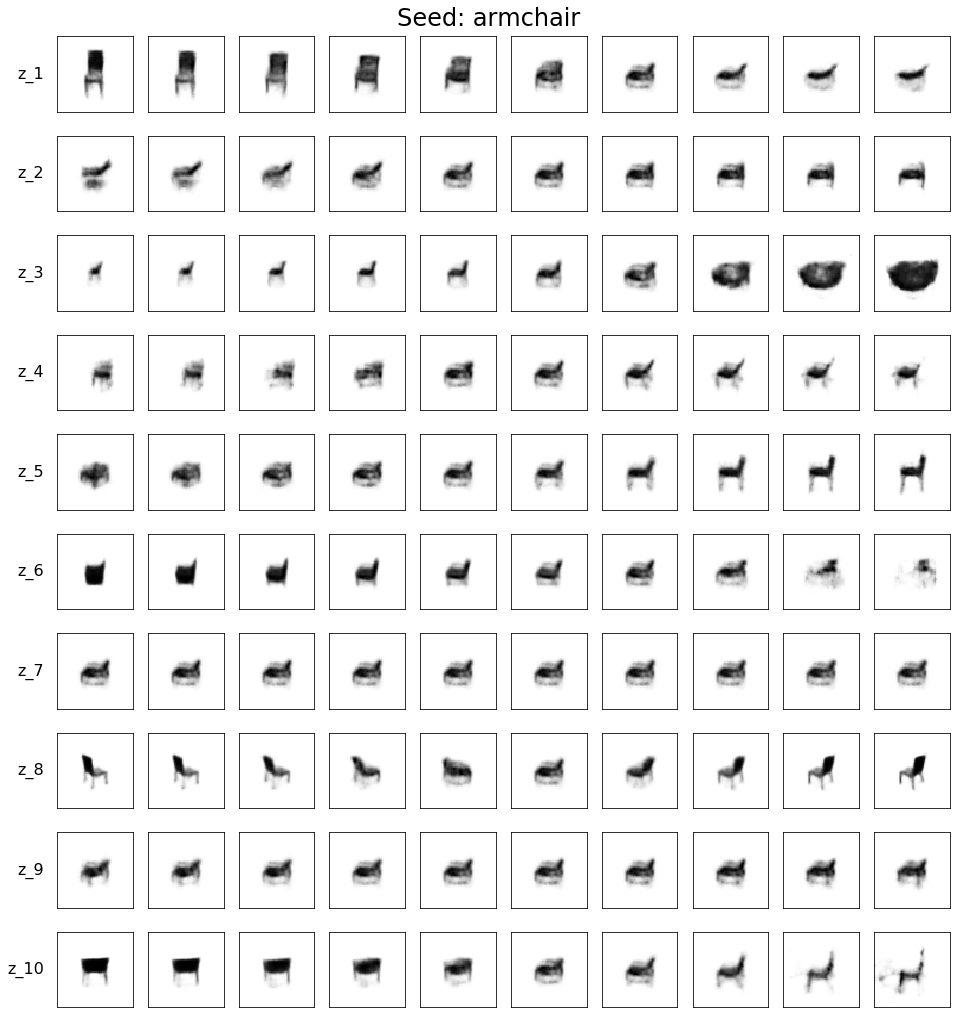

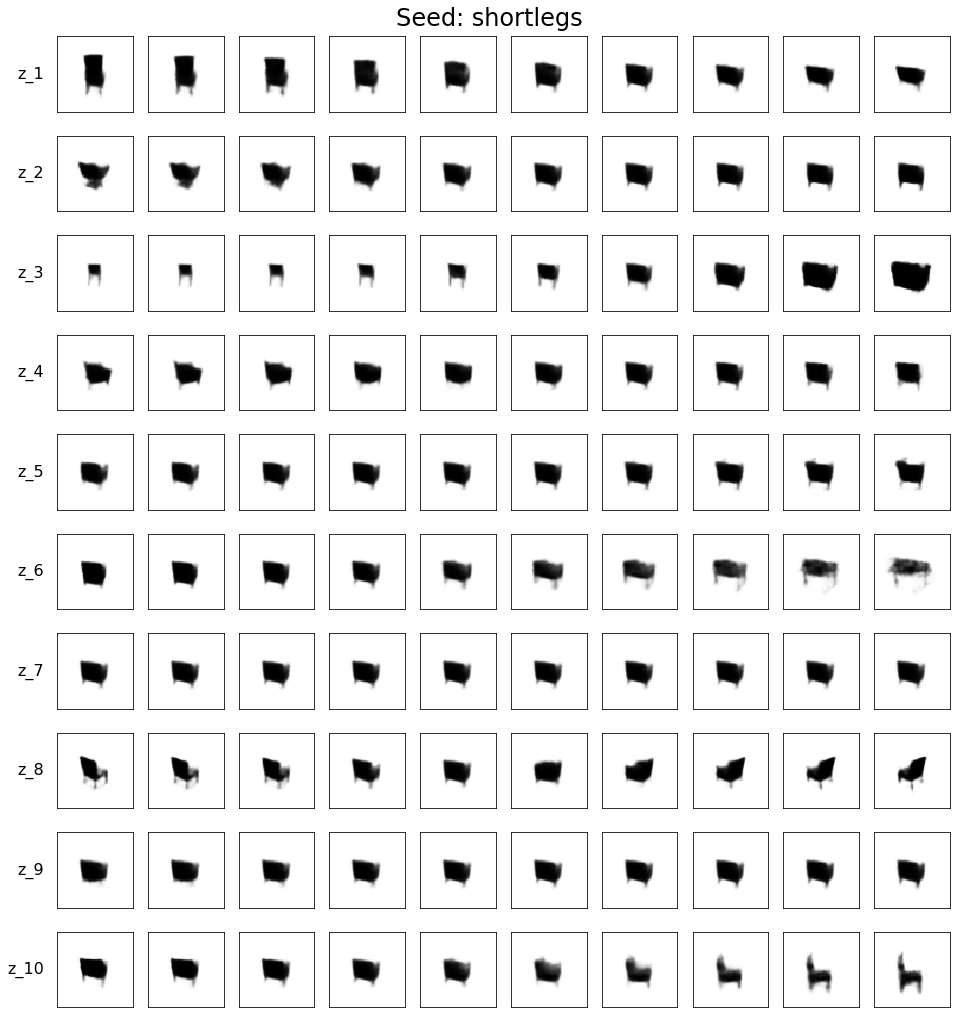

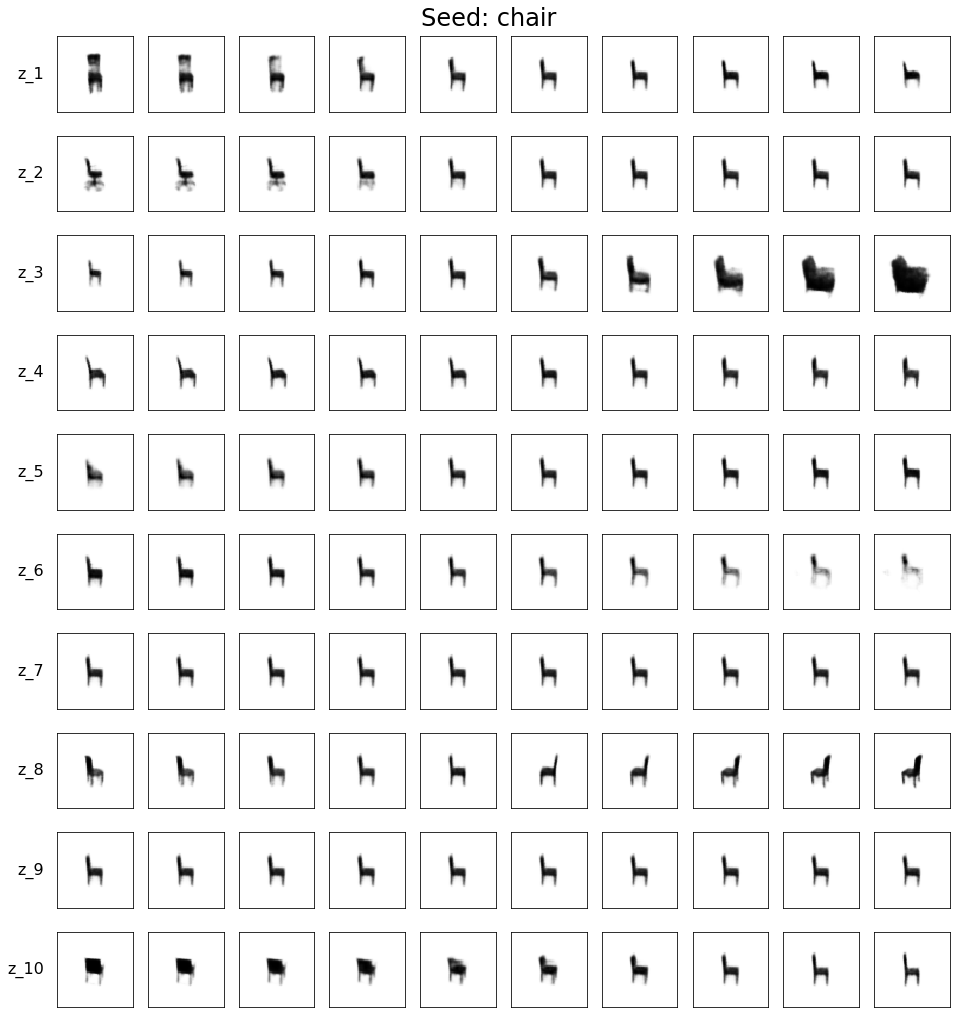

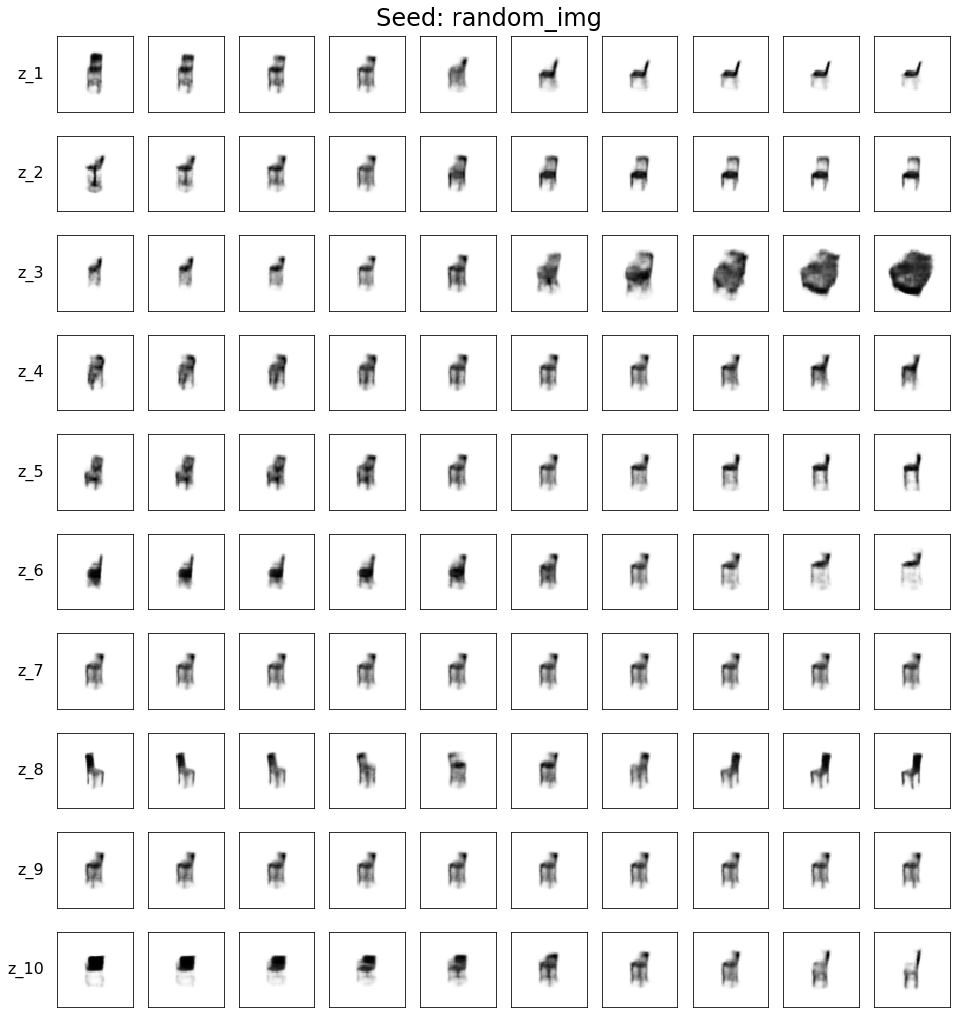

In [13]:
for key in Z.keys():
    z_ori = Z[key]
    samples = []
    for row in range(z_dim):
        z = z_ori.clone()
        for val in interpolation:
            z[row] = val
            sample = torch.sigmoid(net.decoder(z)).data
            samples.append(sample)
    samples = torch.cat(samples, dim=0).cpu()
    
    fig , axes = plt.subplots(10,10, figsize=(16,18))
    fig.suptitle (f'Seed: {key}', y=0.9, size=24)
    for ax, img in zip(axes.flatten(), samples):
        ax.imshow(img[0], cmap='binary_r')
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        
    # Annotating rows
    rows = [f'z_{num}' for num in range(1,11)]     
    counter = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx%10 == 0:
            ax.annotate(rows[counter], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size=16, ha='right', va='center')  
            counter += 1